In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/bnabnubne/DAV/EMS_CLEAN_FULL.csv")

print(df.shape)
df.head()

(219744, 8)


,IMAGE,FIX_INDEX,FIX_DURATION,FIX_X,FIX_Y,FIX_PUPIL,SUBJECT_ID,GROUP
0,outman_054.jpg,1,205,518.5,371.3,1177,0,HEALTHY
1,outman_054.jpg,2,90,275.1,282.2,1262,0,HEALTHY
2,outman_054.jpg,3,305,600.3,271.1,1265,0,HEALTHY
3,outman_054.jpg,4,269,635.2,269.2,1326,0,HEALTHY
4,outman_054.jpg,5,318,597.3,266.0,1366,0,HEALTHY


In [25]:
fix_features = df.groupby("SUBJECT_ID").agg(
    MEAN_DURATION = ("FIX_DURATION", "mean"),
    STD_DURATION = ("FIX_DURATION", "std"),
    CV_DURATION = ("FIX_DURATION", lambda x: np.std(x) / np.mean(x)),
    PROP_LONG_FIX = ("FIX_DURATION", lambda x: np.mean(x > 400)),
    FIX_COUNT = ("FIX_DURATION", "count")
).reset_index()

In [26]:
spatial = df.groupby("SUBJECT_ID").agg(
    SPATIAL_STD_X = ("FIX_X", "std"),
    SPATIAL_STD_Y = ("FIX_Y", "std")
).reset_index()

fix_features = fix_features.merge(spatial, on="SUBJECT_ID")

In [27]:
def compute_saccade_features(subject_df):
    subject_df = subject_df.sort_values("FIX_INDEX")

    x = subject_df["FIX_X"].values
    y = subject_df["FIX_Y"].values

    dx = np.diff(x)
    dy = np.diff(y)
    amp = np.sqrt(dx**2 + dy**2)  # saccade amplitude

    return pd.Series({
        "SAC_MEAN_AMP": np.mean(amp),
        "SAC_STD_AMP": np.std(amp),
        "SAC_MAX_AMP": np.max(amp),
        "SAC_COUNT": len(amp)
    })

sacc_features = df.groupby("SUBJECT_ID").apply(compute_saccade_features).reset_index()
fix_features = fix_features.merge(sacc_features, on="SUBJECT_ID")

In [28]:
def compute_entropy(subject_df, bins=25):
    H, _, _ = np.histogram2d(
        subject_df["FIX_X"],
        subject_df["FIX_Y"],
        bins=bins
    )
    P = H / np.sum(H)
    P = P[P > 0]
    entropy = -np.sum(P * np.log2(P))
    return entropy

entropy_df = df.groupby("SUBJECT_ID").apply(
    lambda s: pd.Series({"HM_ENTROPY": compute_entropy(s)})
).reset_index()

fix_features = fix_features.merge(entropy_df, on="SUBJECT_ID")

In [29]:
from scipy.ndimage import gaussian_filter

def compute_compactness(subject_df):
    heat = np.zeros((768, 1024))

    xs = subject_df["FIX_X"].astype(int)
    ys = subject_df["FIX_Y"].astype(int)

    for x, y in zip(xs, ys):
        if 0 <= x < 1024 and 0 <= y < 768:
            heat[y, x] += 1

    heat = gaussian_filter(heat, sigma=20)
    heat_norm = heat / heat.max()

    high_region = (heat_norm > 0.6).sum()
    return high_region / heat_norm.size

compact_df = df.groupby("SUBJECT_ID").apply(
    lambda s: pd.Series({"HM_COMPACTNESS": compute_compactness(s)})
).reset_index()

fix_features = fix_features.merge(compact_df, on="SUBJECT_ID")

In [30]:
pupil_df = df.groupby("SUBJECT_ID").agg(
    PUPIL_STD = ("FIX_PUPIL", "std"),
    PUPIL_CV = ("FIX_PUPIL", lambda x: np.std(x) / np.mean(x)),
    PUPIL_DERIV_STD = ("FIX_PUPIL", lambda x: np.std(np.diff(x)))
).reset_index()

fix_features = fix_features.merge(pupil_df, on="SUBJECT_ID")

In [31]:
group_df = df[["SUBJECT_ID", "GROUP"]].drop_duplicates()
df_features = fix_features.merge(group_df, on="SUBJECT_ID")

In [32]:
df_features.to_csv("/Users/bnabnubne/DAV/EMS_FEATURES_EXTENDED.csv", index=False)
print("Saved: EMS_FEATURES_EXTENDED.csv")
print(df_features.shape)
df_features.head()

Saved: EMS_FEATURES_EXTENDED.csv
(160, 18)


,SUBJECT_ID,MEAN_DURATION,STD_DURATION,CV_DURATION,PROP_LONG_FIX,FIX_COUNT,SPATIAL_STD_X,SPATIAL_STD_Y,SAC_MEAN_AMP,SAC_STD_AMP,SAC_MAX_AMP,SAC_COUNT,HM_ENTROPY,HM_COMPACTNESS,PUPIL_STD,PUPIL_CV,PUPIL_DERIV_STD,GROUP
0,0,280.274839,160.980335,0.574181,0.163871,1550,228.124419,153.996067,325.924463,192.424630,972.099306,1549.0,8.424763,0.010246,222.879533,0.170676,144.705071,HEALTHY
1,1,356.936327,284.106378,0.795633,0.293061,1225,198.462006,136.651751,291.811569,180.013922,856.094510,1224.0,8.118209,0.002431,172.487121,0.174568,122.225317,HEALTHY
2,2,266.431462,154.855791,0.581032,0.119452,1532,205.379278,141.699800,299.281214,175.738534,866.818608,1531.0,8.383080,0.002944,99.773010,0.154200,72.079782,HEALTHY
3,3,256.597508,155.731870,0.606722,0.125857,1605,234.905279,160.478247,343.589818,199.155097,987.715232,1604.0,8.537391,0.004066,250.247998,0.259622,122.412226,HEALTHY
4,4,349.456790,443.560990,1.268797,0.195216,1296,207.594235,147.124119,304.197812,182.129736,877.791285,1295.0,8.187113,0.003962,212.593377,0.136460,166.982181,HEALTHY


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_features = pd.read_csv("/Users/bnabnubne/DAV/EMS_FEATURES_EXTENDED.csv")
print(df_features.shape)
df_features.head()

(160, 18)


,SUBJECT_ID,MEAN_DURATION,STD_DURATION,CV_DURATION,PROP_LONG_FIX,FIX_COUNT,SPATIAL_STD_X,SPATIAL_STD_Y,SAC_MEAN_AMP,SAC_STD_AMP,SAC_MAX_AMP,SAC_COUNT,HM_ENTROPY,HM_COMPACTNESS,PUPIL_STD,PUPIL_CV,PUPIL_DERIV_STD,GROUP
0,0,280.274839,160.980335,0.574181,0.163871,1550,228.124419,153.996067,325.924463,192.424630,972.099306,1549.0,8.424763,0.010246,222.879533,0.170676,144.705071,HEALTHY
1,1,356.936327,284.106378,0.795633,0.293061,1225,198.462006,136.651751,291.811569,180.013922,856.094510,1224.0,8.118209,0.002431,172.487121,0.174568,122.225317,HEALTHY
2,2,266.431462,154.855791,0.581032,0.119452,1532,205.379278,141.699800,299.281214,175.738534,866.818608,1531.0,8.383080,0.002944,99.773010,0.154200,72.079782,HEALTHY
3,3,256.597508,155.731870,0.606722,0.125857,1605,234.905279,160.478247,343.589818,199.155097,987.715232,1604.0,8.537391,0.004066,250.247998,0.259622,122.412226,HEALTHY
4,4,349.456790,443.560990,1.268797,0.195216,1296,207.594235,147.124119,304.197812,182.129736,877.791285,1295.0,8.187113,0.003962,212.593377,0.136460,166.982181,HEALTHY


In [34]:
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["SUBJECT_ID"]]  # bỏ Subject_id

numeric_cols


['MEAN_DURATION',
 'STD_DURATION',
 'CV_DURATION',
 'PROP_LONG_FIX',
 'FIX_COUNT',
 'SPATIAL_STD_X',
 'SPATIAL_STD_Y',
 'SAC_MEAN_AMP',
 'SAC_STD_AMP',
 'SAC_MAX_AMP',
 'SAC_COUNT',
 'HM_ENTROPY',
 'HM_COMPACTNESS',
 'PUPIL_STD',
 'PUPIL_CV',
 'PUPIL_DERIV_STD']

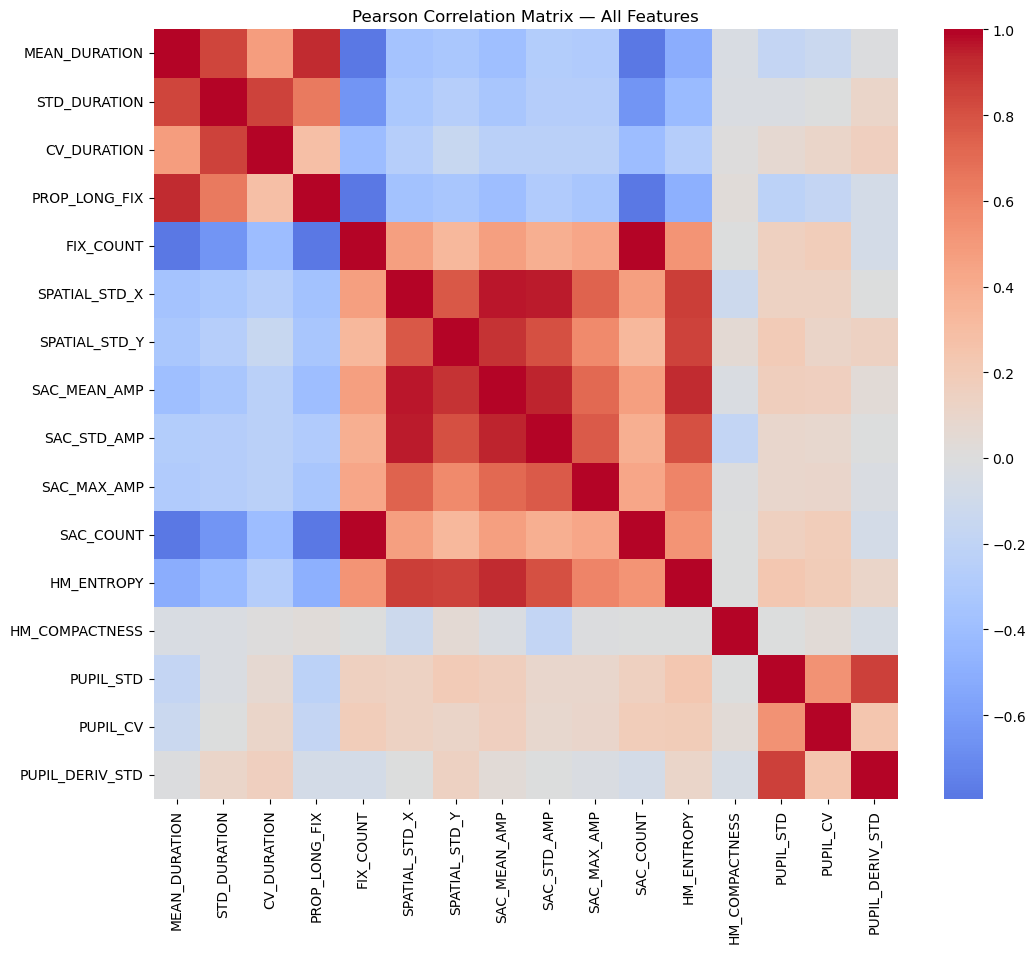

In [35]:
plt.figure(figsize=(12,10))
corr = df_features[numeric_cols].corr(method="pearson")

sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation Matrix — All Features")
plt.show()

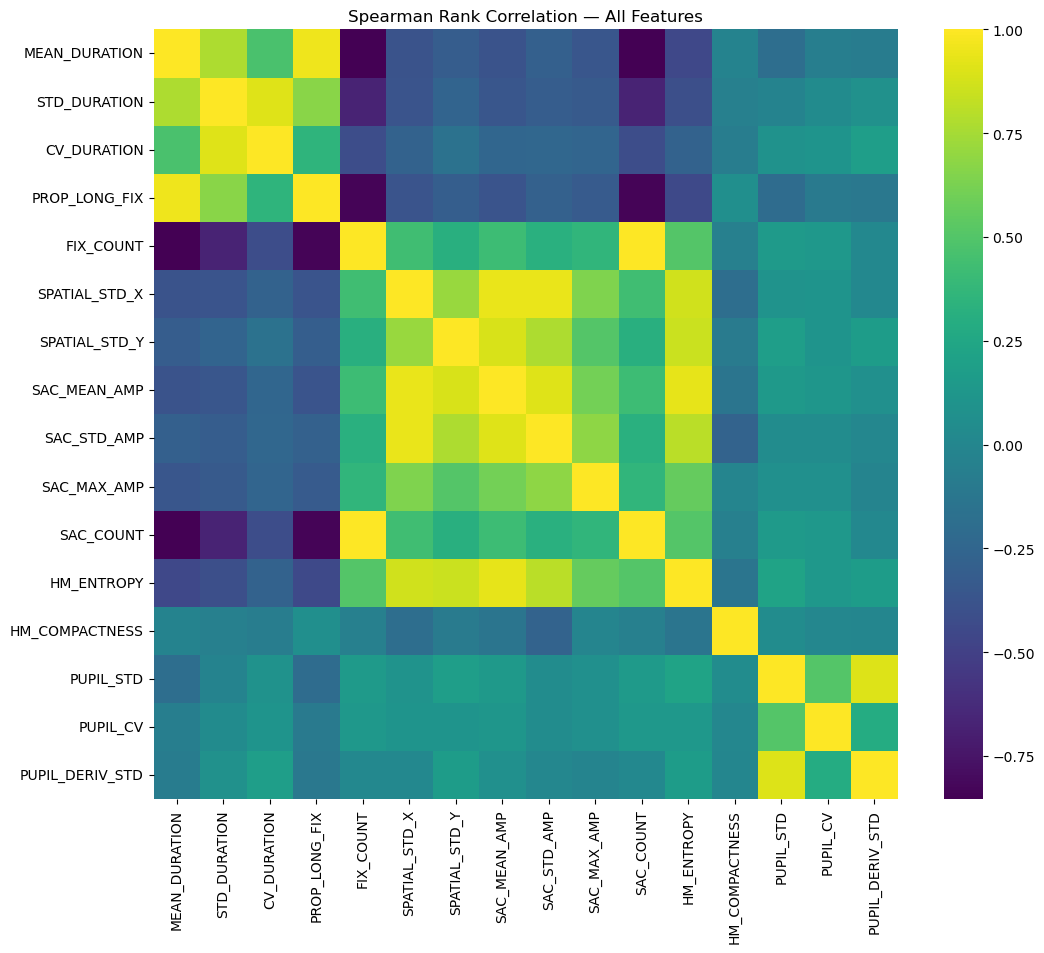

In [36]:
plt.figure(figsize=(12,10))
corr_s = df_features[numeric_cols].corr(method="spearman")

sns.heatmap(corr_s, annot=False, cmap="viridis")
plt.title("Spearman Rank Correlation — All Features")
plt.show()

In [37]:
corr_pairs = corr.abs().unstack().sort_values(ascending=False)

# bỏ self-correlation (1.0)
corr_pairs = corr_pairs[corr_pairs < 0.999]

print("Top 15 strongest correlations:")
corr_pairs.head(15)

Top 15 strongest correlations:


SPATIAL_STD_X    SAC_MEAN_AMP     0.960075
SAC_MEAN_AMP     SPATIAL_STD_X    0.960075
SAC_STD_AMP      SPATIAL_STD_X    0.955694
SPATIAL_STD_X    SAC_STD_AMP      0.955694
SAC_STD_AMP      SAC_MEAN_AMP     0.939462
SAC_MEAN_AMP     SAC_STD_AMP      0.939462
                 HM_ENTROPY       0.924527
HM_ENTROPY       SAC_MEAN_AMP     0.924527
MEAN_DURATION    PROP_LONG_FIX    0.922532
PROP_LONG_FIX    MEAN_DURATION    0.922532
SPATIAL_STD_Y    SAC_MEAN_AMP     0.898462
SAC_MEAN_AMP     SPATIAL_STD_Y    0.898462
HM_ENTROPY       SPATIAL_STD_X    0.869479
SPATIAL_STD_X    HM_ENTROPY       0.869479
PUPIL_DERIV_STD  PUPIL_STD        0.863064
dtype: float64

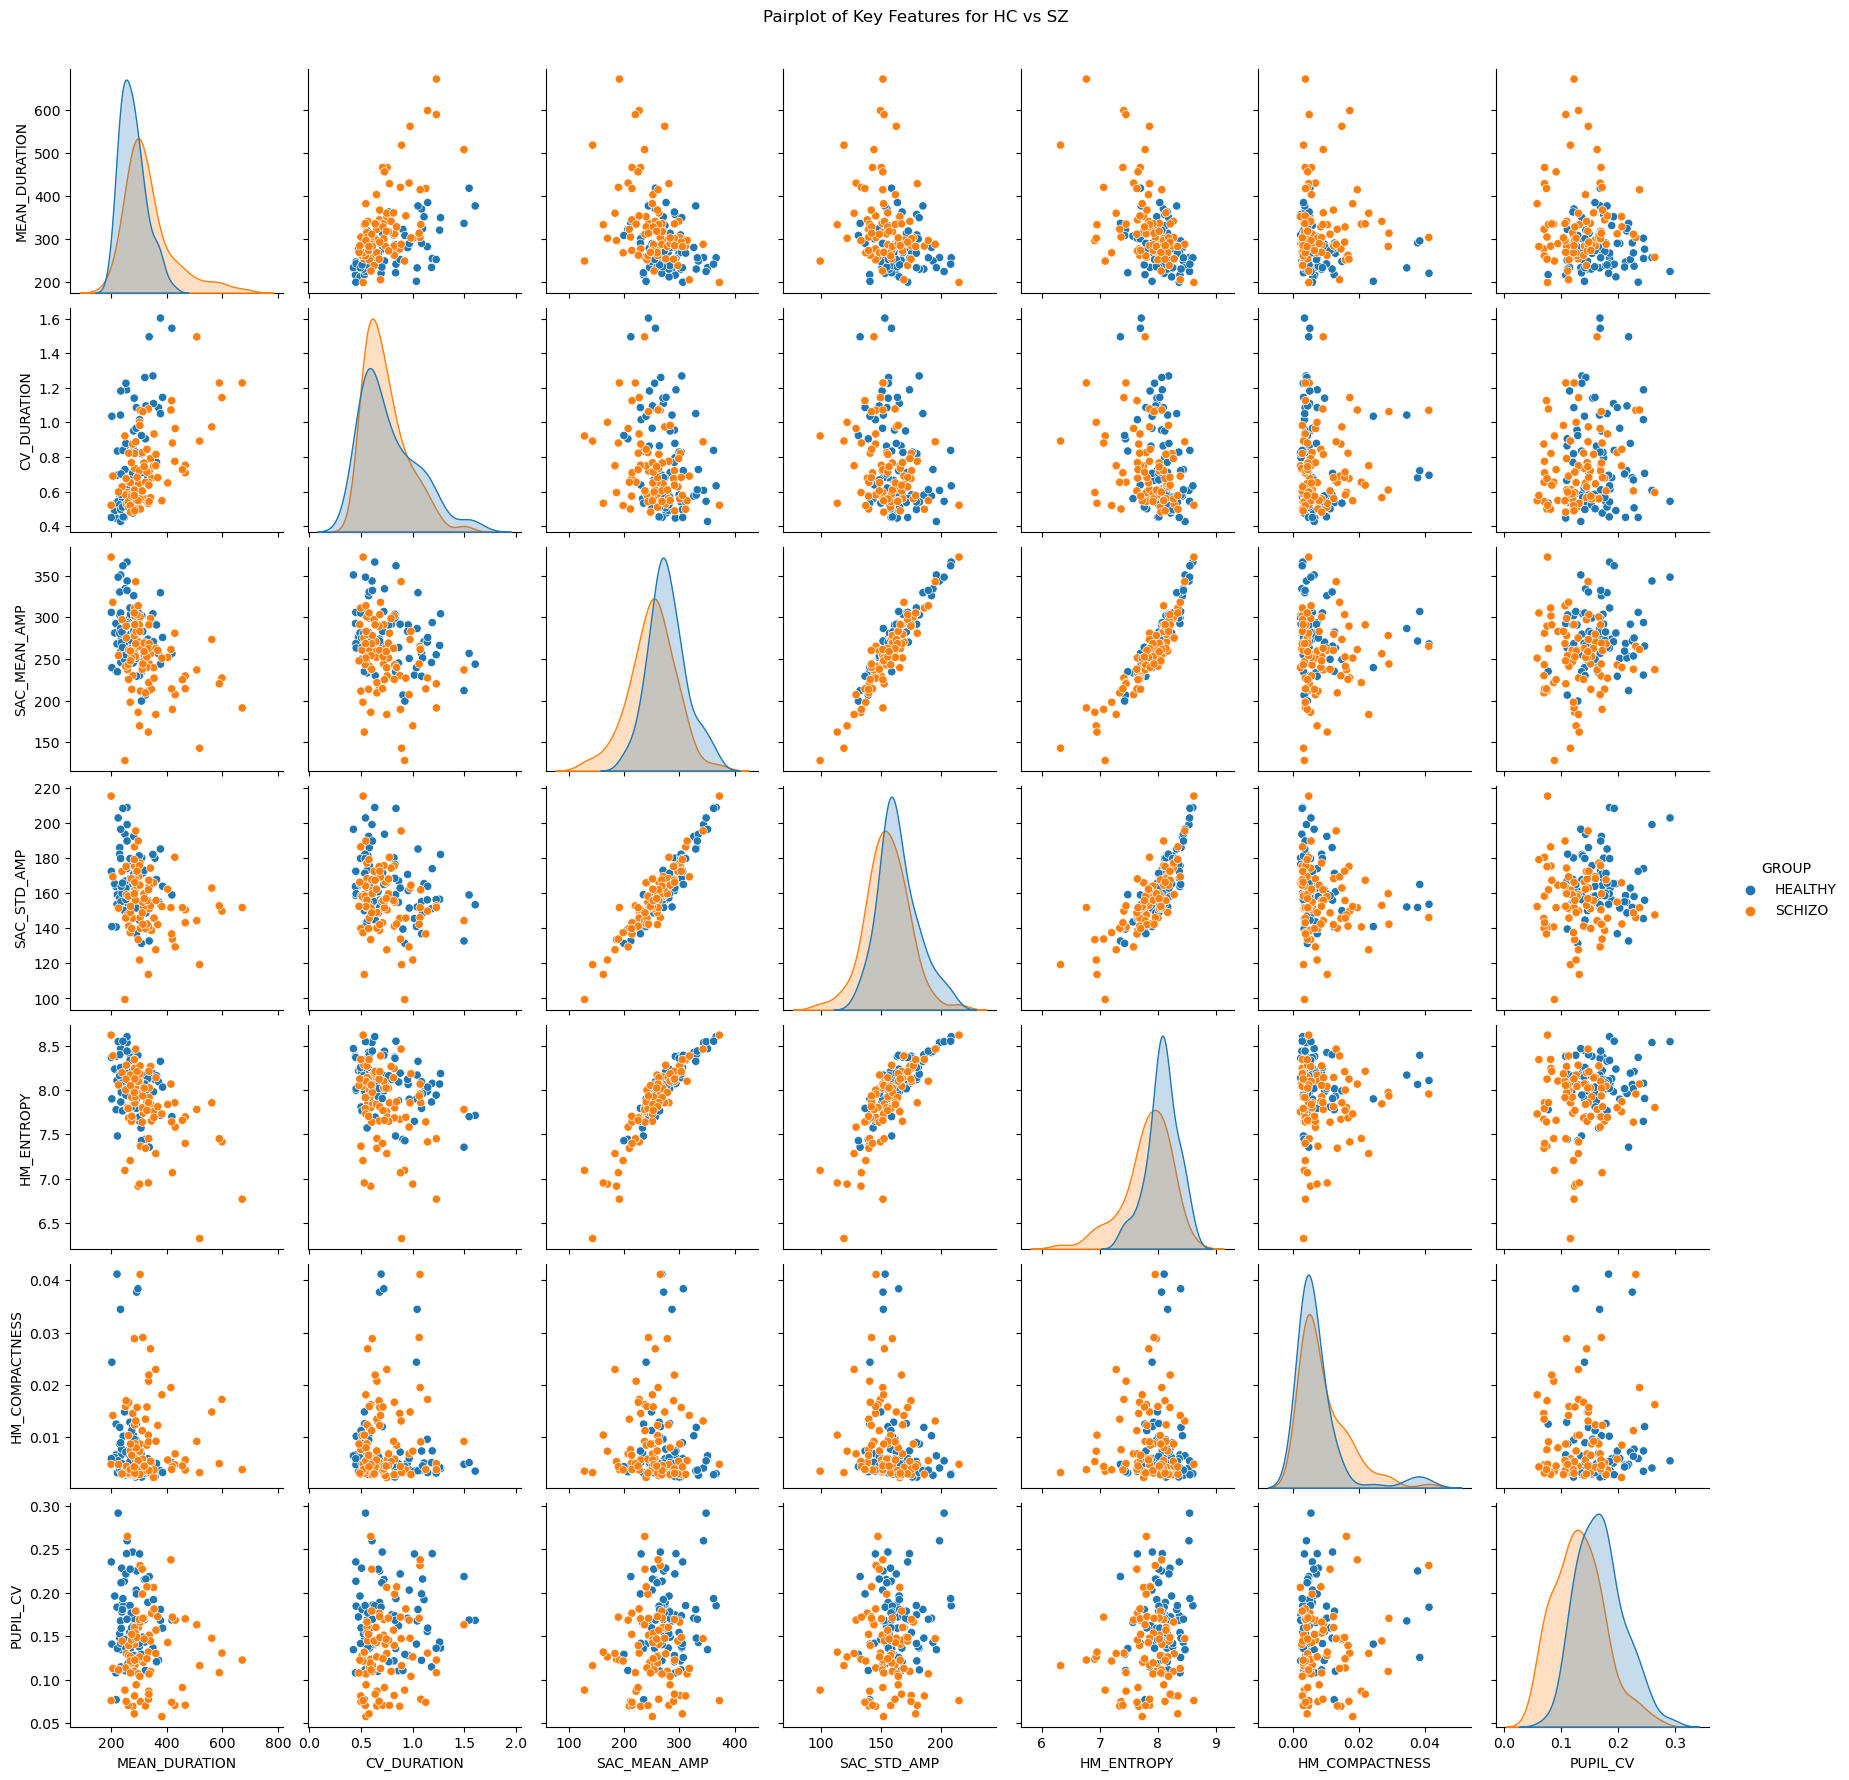

In [38]:
selected = [
    "MEAN_DURATION",
    "CV_DURATION",
    "SAC_MEAN_AMP",
    "SAC_STD_AMP",
    "HM_ENTROPY",
    "HM_COMPACTNESS",
    "PUPIL_CV",
    "GROUP"
]

sns.pairplot(df_features[selected], hue="GROUP", diag_kind="kde")
plt.suptitle("Pairplot of Key Features for HC vs SZ", y=1.02)
plt.show()

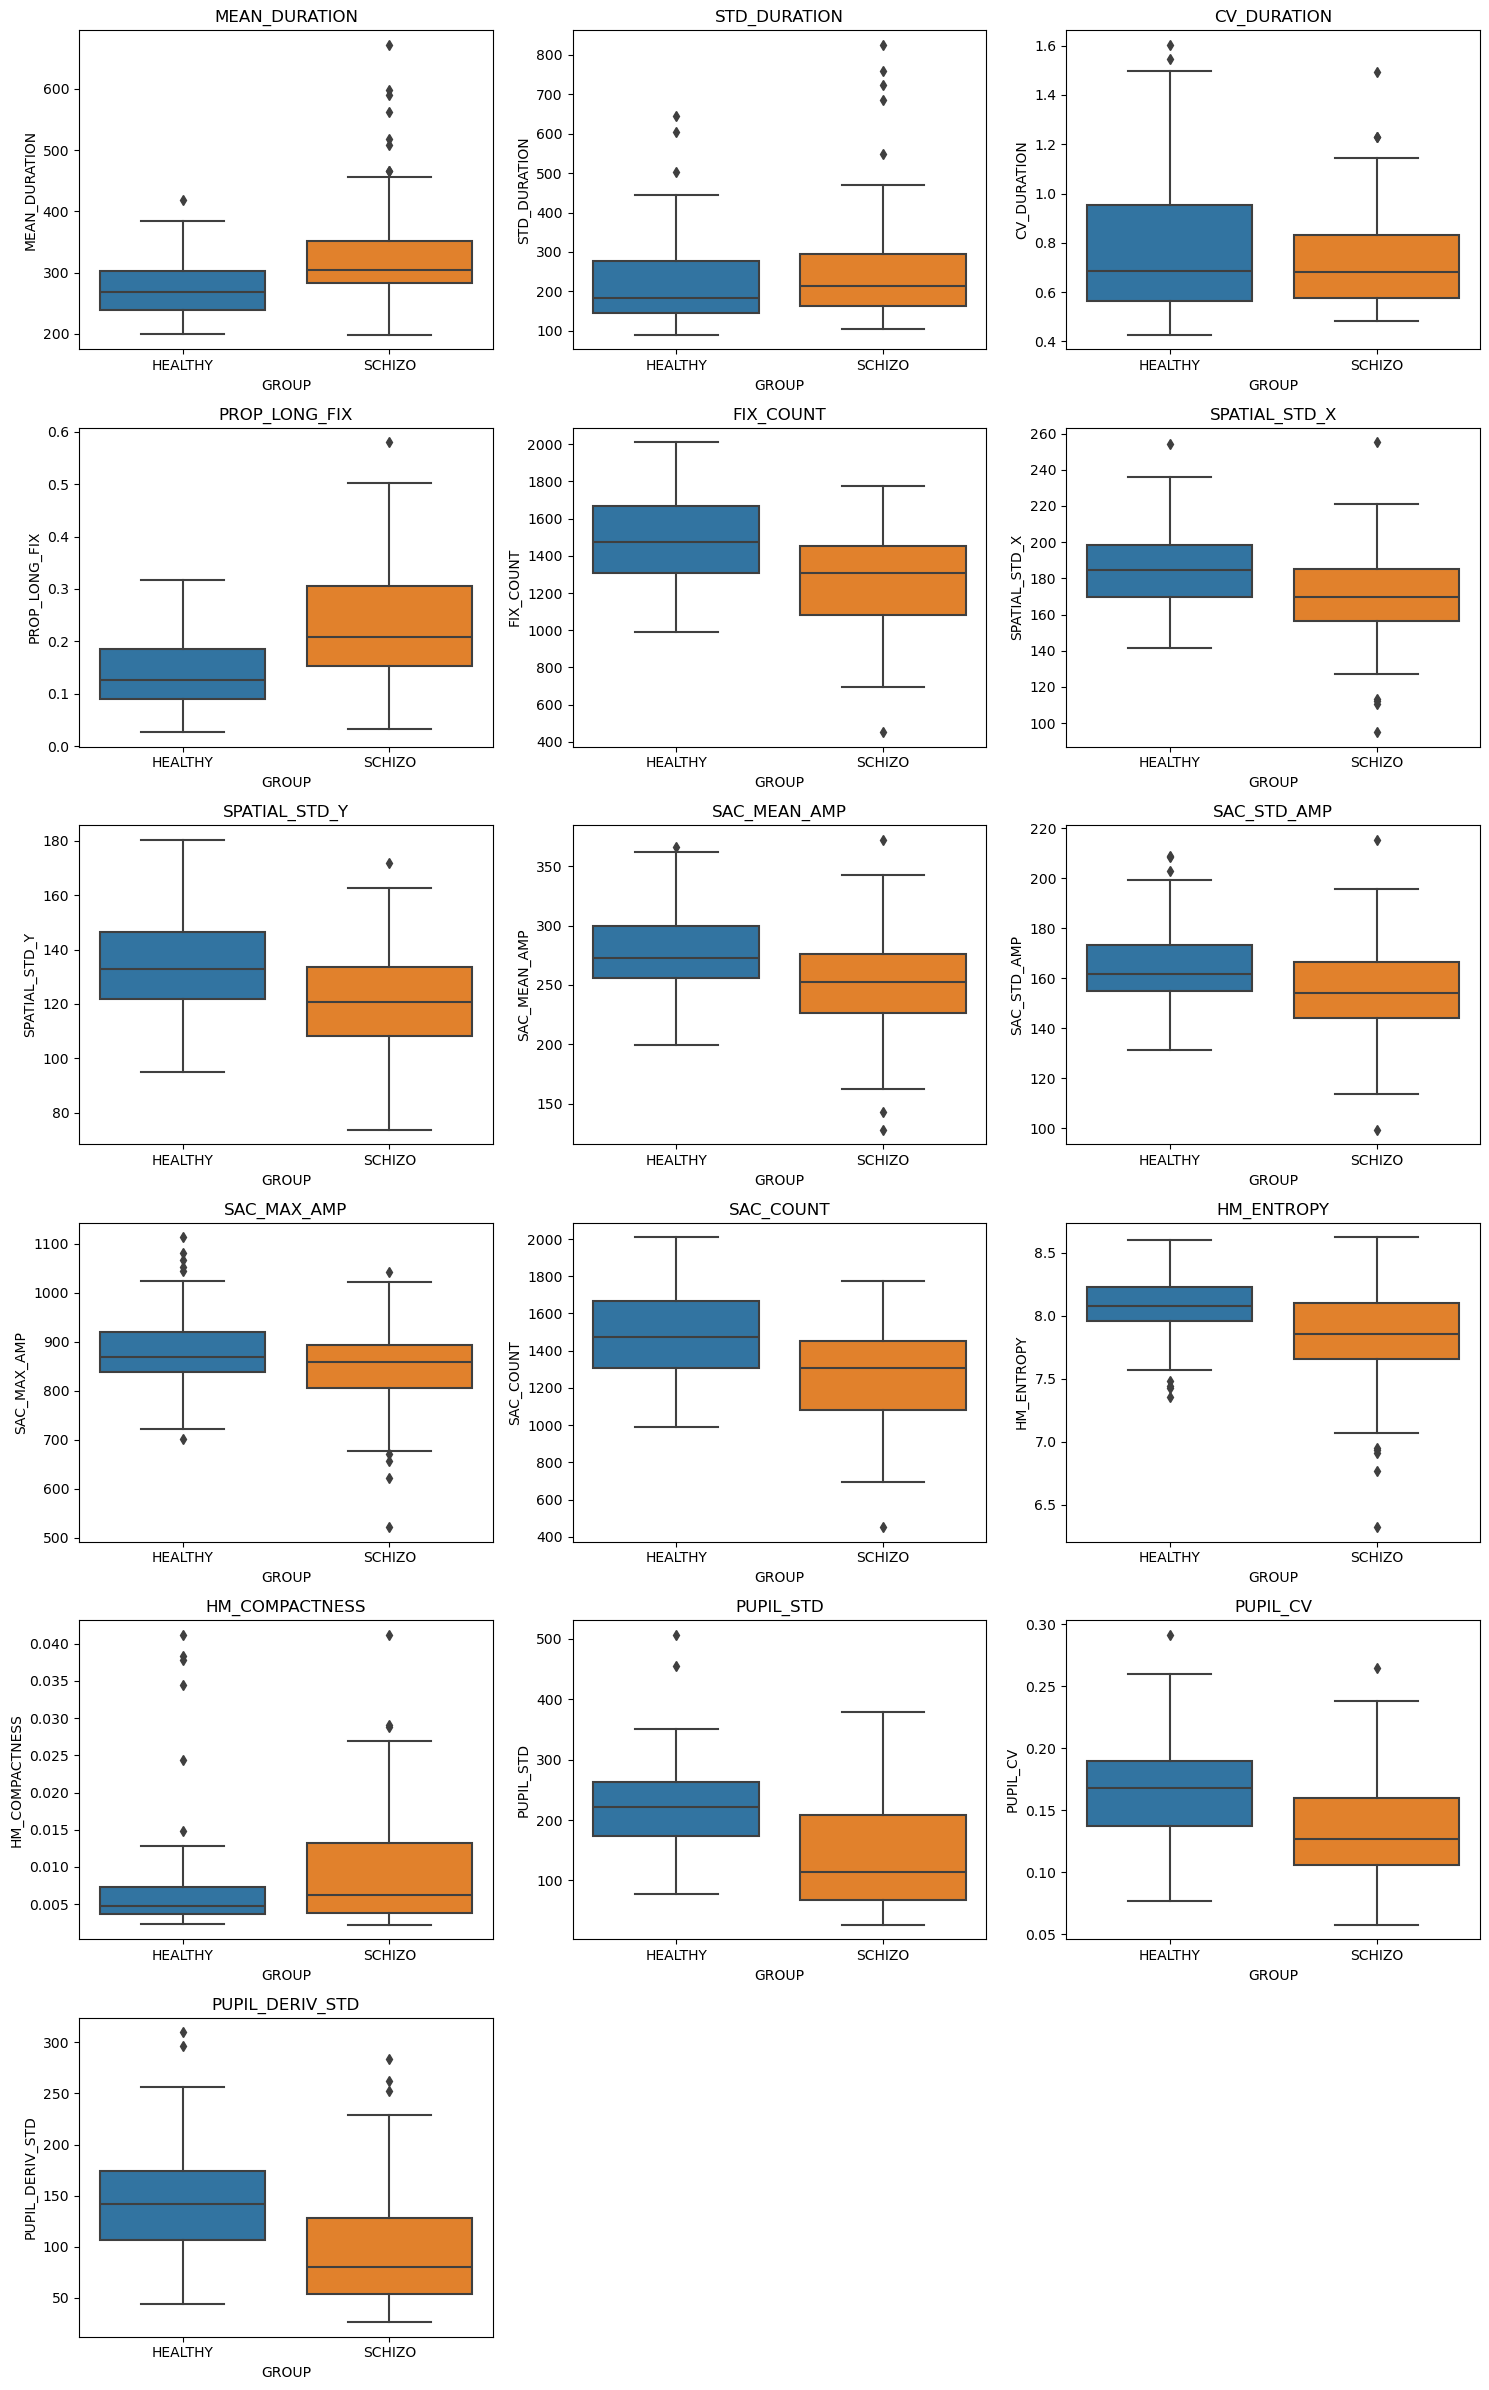

In [39]:
import math

cols = [c for c in numeric_cols if c != "GROUP"]
n = len(cols)
rows = math.ceil(n/3)

plt.figure(figsize=(15, 4*rows))

for i, col in enumerate(cols):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(data=df_features, x="GROUP", y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

=== Mutual Information Scores ===
SUBJECT_ID         0.696282
FIX_COUNT          0.202856
SAC_COUNT          0.194701
PUPIL_STD          0.136212
MEAN_DURATION      0.132124
PUPIL_DERIV_STD    0.113511
PROP_LONG_FIX      0.106057
PUPIL_CV           0.082168
STD_DURATION       0.073549
SAC_MEAN_AMP       0.060581
HM_ENTROPY         0.057099
SPATIAL_STD_X      0.053560
CV_DURATION        0.048283
SPATIAL_STD_Y      0.037643
SAC_MAX_AMP        0.037291
SAC_STD_AMP        0.000000
HM_COMPACTNESS     0.000000
dtype: float64


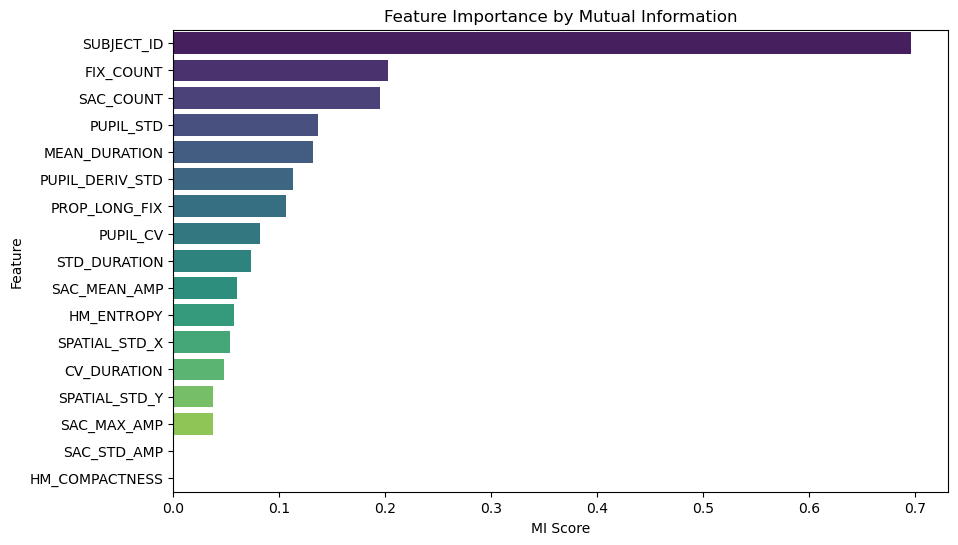

In [42]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==== CHUẨN BỊ DỮ LIỆU ====
df_fs = df_features.copy()
df_fs['GROUP_LABEL'] = df_fs['GROUP'].map({'HEALTHY':0, 'SCHIZO':1})

X = df_fs.drop(columns=['GROUP', 'GROUP_LABEL'])
y = df_fs['GROUP_LABEL']

# ==== TÍNH MUTUAL INFORMATION ====
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("=== Mutual Information Scores ===")
print(mi_series)

# ==== VISUALIZE ====
plt.figure(figsize=(10,6))
sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
plt.title("Feature Importance by Mutual Information")
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.show()

In [43]:
X = df_features.drop(columns=["GROUP", "SUBJECT_ID"])
y = df_features["GROUP"].map({"HEALTHY":0, "SCHIZO":1})

In [44]:
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
X_disc = kb.fit_transform(X)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [45]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_disc, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

PROP_LONG_FIX      0.189852
FIX_COUNT          0.139987
SAC_COUNT          0.128892
PUPIL_DERIV_STD    0.104310
PUPIL_STD          0.097283
PUPIL_CV           0.055477
HM_ENTROPY         0.037459
SAC_MEAN_AMP       0.032188
MEAN_DURATION      0.029319
HM_COMPACTNESS     0.007926
SPATIAL_STD_Y      0.005525
SPATIAL_STD_X      0.003347
STD_DURATION       0.000000
CV_DURATION        0.000000
SAC_STD_AMP        0.000000
SAC_MAX_AMP        0.000000
dtype: float64


In [48]:
selected_features = [
    "PROP_LONG_FIX",
    "FIX_COUNT",
    "SAC_COUNT",
    "PUPIL_DERIV_STD",
    "PUPIL_STD",
    "PUPIL_CV",
    "MEAN_DURATION",
    "HM_ENTROPY",
    "SAC_MEAN_AMP"
]

X = df_features[selected_features].copy()
y = df_features["GROUP"].map({"HEALTHY": 0, "SCHIZO": 1})

In [49]:
X.isna().sum(), y.isna().sum()

(PROP_LONG_FIX      0
 FIX_COUNT          0
 SAC_COUNT          0
 PUPIL_DERIV_STD    0
 PUPIL_STD          0
 PUPIL_CV           0
 MEAN_DURATION      0
 HM_ENTROPY         0
 SAC_MEAN_AMP       0
 dtype: int64,
 0)

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    "Logistic": LogisticRegression(),
    "SVM-Linear": SVC(kernel="linear", probability=True),
    "RandomForest": RandomForestClassifier(),
    "LDA-Classifier": LinearDiscriminantAnalysis()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, pred):.4f}")

Logistic Accuracy: 0.8125
SVM-Linear Accuracy: 0.6875
RandomForest Accuracy: 0.7188
LDA-Classifier Accuracy: 0.7812


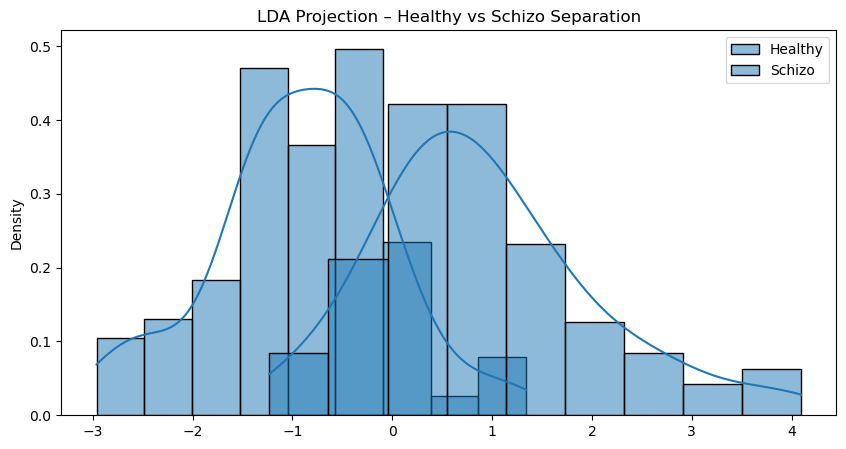

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

plt.figure(figsize=(10,5))
sns.histplot(X_lda[y==0], kde=True, color="blue", label="Healthy", stat="density")
sns.histplot(X_lda[y==1], kde=True, color="red", label="Schizo", stat="density")
plt.title("LDA Projection – Healthy vs Schizo Separation")
plt.legend()
plt.show()

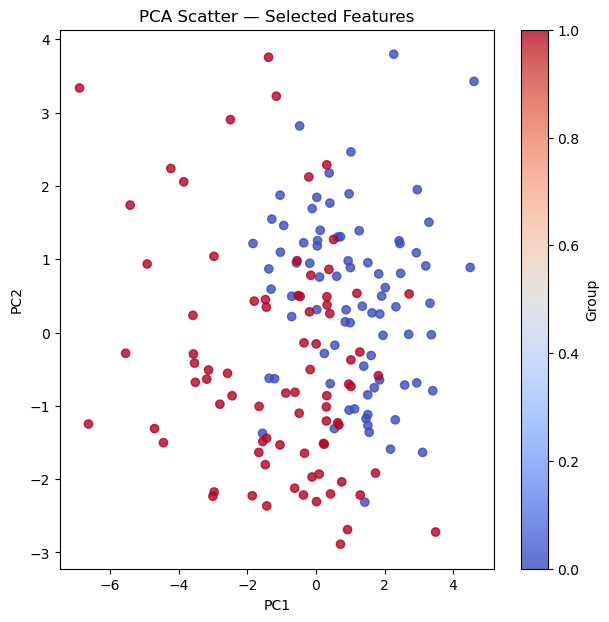

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.8)
plt.title("PCA Scatter — Selected Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Group")
plt.show()

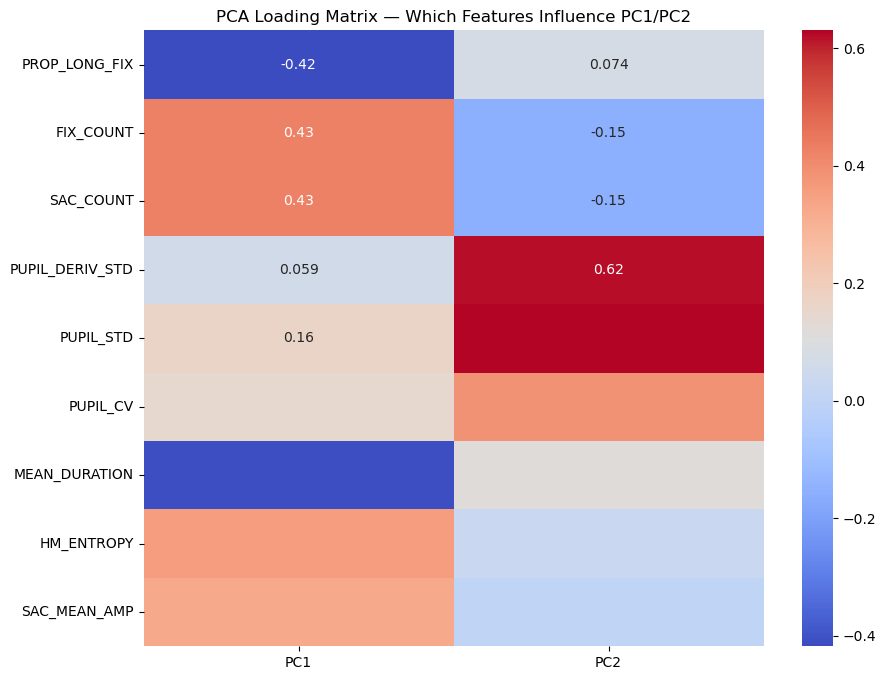

In [54]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=selected_features,
    columns=["PC1","PC2"]
)

plt.figure(figsize=(10,8))
sns.heatmap(loadings, annot=True, cmap="coolwarm")
plt.title("PCA Loading Matrix — Which Features Influence PC1/PC2")
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score

model = LogisticRegression()
model.fit(X_train, y_train)
proba = model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, proba))

ROC-AUC: 0.8671875


In [65]:
df_features["LABEL"] = df_features["GROUP"].map({"HEALTHY": 0, "SCHIZO": 1})

# Columns to keep
final_cols = ["SUBJECT_ID"] + selected_features + ["LABEL"]

df_final = df_features[final_cols].copy()

output_path = "/Users/bnabnubne/DAV/EMS_FEATURES_FINAL.csv"
df_final.to_csv(output_path, index=False)

print("FINAL FEATURESET SAVED TO:", output_path)
print(df_final.head())
print(df_final.shape)

FINAL FEATURESET SAVED TO: /Users/bnabnubne/DAV/EMS_FEATURES_FINAL.csv
   SUBJECT_ID  PROP_LONG_FIX  FIX_COUNT  SAC_COUNT  PUPIL_DERIV_STD  \
0           0       0.163871       1550     1549.0       144.705071   
1           1       0.293061       1225     1224.0       122.225317   
2           2       0.119452       1532     1531.0        72.079782   
3           3       0.125857       1605     1604.0       122.412226   
4           4       0.195216       1296     1295.0       166.982181   

    PUPIL_STD  PUPIL_CV  MEAN_DURATION  HM_ENTROPY  SAC_MEAN_AMP  LABEL  
0  222.879533  0.170676     280.274839    8.424763    325.924463      0  
1  172.487121  0.174568     356.936327    8.118209    291.811569      0  
2   99.773010  0.154200     266.431462    8.383080    299.281214      0  
3  250.247998  0.259622     256.597508    8.537391    343.589818      0  
4  212.593377  0.136460     349.456790    8.187113    304.197812      0  
(160, 11)
